In [11]:
import pandas as pd
import time
import numpy as np
from sklearn.model_selection import train_test_split
import lightgbm as lgb
import gc
import matplotlib.pyplot as plt
import os
import pickle

(continue with feature engineering1)
* original features: ip, app, device, os, channel
* click_time feature: day, weekday, hour, minutes, seconds
* count features: 
    * ip 
    * app
    * os
    * channel
    * ip, app
    * ip, device
    * ip, os
    * app, device
    * app, channel
    * app, os
    * ip, device, app
    * ip, device, os
    * ip, os, channel
    * ip, app, channel
* nunique-count feature
    * ip [app]
    * ip [device]
    * ip [os]
    * ip [channel]
    * app [os]
    * app [channel]
    * ip, app [os]
    * ip, app [device]
    * ip, device, os [app]
    * ip, day [hour]
* previous_click_time
    * day ip device os/first time
    * day ip device os app/first time
 
* total 38 features

In [12]:
training_set = pd.read_csv('/Volumes/My Passport for Mac/training_set2.csv', index_col = 0)

/anaconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:472: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [6]:
train_y = pd.read_csv('/Users/mengruiyin/Dropbox/project3/project3_coding/train_set_y.csv')

In [7]:
training_set['is_attributed'] = train_y['is_attributed'].values

In [8]:
training_set.shape

(65128309, 39)

In [24]:
training_set['is_attributed'].value_counts(normalize = True)

0    0.997581
1    0.002419
Name: is_attributed, dtype: float64

In [13]:
training_set = training_set[training_set.hour!=12]

##### To fit the model, I split the train to training set and testing set (to differentiate the testing set and the test set which provided by the talkingdata for prediction, I called testing set validation set here.)

##### the training set were from the train data whose click time was Nov 8th while the validation data were from the train data whose click time were Nov 9th. There were around 30 million rows for the training set and 30 millions rows for the validation set.

##### the model was gradient boosting model

In [14]:
training_set = training_set[training_set.day == 8]

In [15]:
training_set.shape

(30194930, 38)

In [20]:
del train_y
gc.collect()

14

In [25]:
predictors = list(training_set.columns)[0:38]

In [26]:
target = 'is_attributed'

In [27]:
categorical =  ['ip','app', 'device', 'os', 'channel', 'hour']

In [28]:
xgtrain = lgb.Dataset(training_set[predictors].values, label=training_set[target].values,
                          feature_name=predictors,
                          categorical_feature=categorical
                          )

In [29]:
del training_set
gc.collect()

0

In [30]:
validation_set = pd.read_csv('/Users/mengruiyin/Dropbox/project3/project3_coding/validation_set.csv', index_col = 0)

/anaconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:472: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [31]:
validation_y = pd.read_csv('/Users/mengruiyin/Dropbox/project3/project3_coding/validation_set_y.csv', index_col = 0)

/anaconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:472: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [32]:
validation_set['is_attributed'] = validation_y['is_attributed'].values

In [33]:
validation_set = validation_set[validation_set.hour != 12]

In [34]:
validation_set.shape

(30840433, 39)

In [35]:
del validation_y
gc.collect()

28

In [36]:
xgvalid = lgb.Dataset(validation_set[predictors].values, label=validation_set[target].values,
                          feature_name=predictors,
                          categorical_feature=categorical
                          )

In [37]:
del validation_set
gc.collect()

7

In [38]:
params = {
        'learning_rate': 0.10,
        #'is_unbalance': 'true', # replaced with scale_pos_weight argument
        'num_leaves': 7,  # 2^max_depth - 1
        'max_depth': 5,  # -1 means no limit
        'min_child_samples': 50,  # Minimum number of data need in a child(min_data_in_leaf)
        'max_bin': 100,  # Number of bucketed bin for feature values
        'subsample': 0.7,  # Subsample ratio of the training instance.
        'subsample_freq': 1,  # frequence of subsample, <=0 means no enable
        'colsample_bytree': 0.9,  # Subsample ratio of columns when constructing each tree.
        'min_child_weight': 0,  # Minimum sum of instance weight(hessian) needed in a child(leaf)
        'scale_pos_weight':200 # because training data is extremely unbalanced 
    }

In [39]:
lgb_params = {
        'boosting_type': 'gbdt',
        'objective': 'binary',
        'metric':'auc',
        'learning_rate': 0.05,
        #'is_unbalance': 'true',  #because training data is unbalance (replaced with scale_pos_weight)
        'num_leaves': 31,  # we should let it be smaller than 2^(max_depth)
        'max_depth': -1,  # -1 means no limit
        'min_child_samples': 20,  # Minimum number of data need in a child(min_data_in_leaf)
        'max_bin': 255,  # Number of bucketed bin for feature values
        'subsample': 0.6,  # Subsample ratio of the training instance.
        'subsample_freq': 0,  # frequence of subsample, <=0 means no enable
        'colsample_bytree': 0.3,  # Subsample ratio of columns when constructing each tree.
        'min_child_weight': 5,  # Minimum sum of instance weight(hessian) needed in a child(leaf)
        'subsample_for_bin': 200000,  # Number of samples for constructing bin
        'min_split_gain': 0,  # lambda_l1, lambda_l2 and min_gain_to_split to regularization
        'reg_alpha': 0,  # L1 regularization term on weights
        'reg_lambda': 0,  # L2 regularization term on weights
        'nthread': 8,
        'verbose': 0,
    }

lgb_params.update(params)

In [28]:
#  feval=None, early_stopping_rounds=50, num_boost_round=3000, verbose_eval=10

In [40]:
evals_results = {}

bst1 = lgb.train(lgb_params, 
                     xgtrain, 
                     valid_sets=[ xgvalid], 
                     valid_names=['valid'], 
                     evals_result=evals_results, 
                     num_boost_round=1000,
                     early_stopping_rounds=50,
                     verbose_eval=10, 
                     feval=None)

print("\nModel Report")
print("bst1.best_iteration: ", bst1.best_iteration)


/Users/mengruiyin/LightGBM/python-package/lightgbm/basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/Users/mengruiyin/LightGBM/python-package/lightgbm/basic.py:681: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[10]	valid's auc: 0.958534
[20]	valid's auc: 0.96143
[30]	valid's auc: 0.964399
[40]	valid's auc: 0.965794
[50]	valid's auc: 0.966414
[60]	valid's auc: 0.967055
[70]	valid's auc: 0.967419
[80]	valid's auc: 0.967852
[90]	valid's auc: 0.968138
[100]	valid's auc: 0.968342
[110]	valid's auc: 0.968607
[120]	valid's auc: 0.968659
[130]	valid's auc: 0.968898
[140]	valid's auc: 0.968918
[150]	valid's auc: 0.968971
[160]	valid's auc: 0.969066
[170]	valid's auc: 0.969113
[180]	valid's auc: 0.969252
[190]	valid's auc: 0.969244
[200]	valid's auc: 0.969253
[210]	valid's auc: 0.969368
[220]	valid's auc: 0.969405
[230]	valid's auc: 0.96939
[240]	valid's auc: 0.969359
[250]	valid's auc: 0.96944
[260]	valid's auc: 0.969424
[270]	valid's auc: 0.969418
[280]	valid's auc: 0.969486
[290]	valid's auc: 0.969488
[300]	valid's auc: 0.969481
[310]	valid's auc: 0.969535
[320]	valid's auc: 0.969508
[330]	valid's auc: 0.96949
[340]	valid's auc: 0.969467

NameError: name 'metrics' is not defined

In [56]:
filename = 'model1.sav'
pickle.dump(bst1, open(filename, 'wb'))

In [41]:
print('auc'+":", evals_results['valid']['auc'][bst1.best_iteration-1])

auc: 0.9695774301373883


##### the auc score for the validation set was 0.9695774301373883

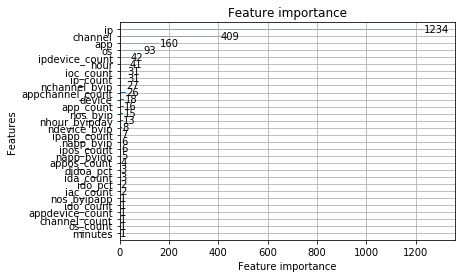

In [43]:
ax = lgb.plot_importance(bst1)
plt.show()

In [2]:
bst1 = pickle.load(open('model1.sav', 'rb'))

In [8]:
feature_importance = {}
for i in range(len(bst1.feature_importance())):
    feature_importance[bst1.feature_name()[i]] = bst1.feature_importance()[i]

In [9]:
feature_importance

{'ip': 1234,
 'app': 160,
 'device': 18,
 'os': 93,
 'channel': 409,
 'day': 0,
 'weekday': 0,
 'hour': 41,
 'minutes': 1,
 'seconds': 0,
 'ip_count': 31,
 'app_count': 16,
 'os_count': 1,
 'channel_count': 1,
 'ipapp_count': 7,
 'ipdevice_count': 42,
 'ipos_count': 6,
 'appdevice_count': 1,
 'appchannel_count': 26,
 'appos_count': 4,
 'ida_count': 3,
 'ido_count': 1,
 'ioc_count': 31,
 'iac_count': 2,
 'ido_pct': 2,
 'didoa_pct': 3,
 'dido_first': 0,
 'didoa_first': 0,
 'napp_byip': 6,
 'ndevice_byip': 8,
 'nos_byip': 15,
 'nchannel_byip': 27,
 'nos_byapp': 0,
 'nchannel_byapp': 0,
 'nos_byipapp': 1,
 'ndevice_byipapp': 0,
 'napp_byido': 5,
 'nhour_byipday': 13}

In [46]:
test = pd.read_csv('/Users/mengruiyin/Dropbox/project3/project3_coding/test_set.csv', index_col = 0)

/anaconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:472: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [48]:
prediction = pd.read_csv('test_id.csv', index_col = 0)

/anaconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:472: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [50]:
prediction['is_attributed'] = bst1.predict(test[predictors],num_iteration=bst1.best_iteration)

In [52]:
prediction.head()

,click_id,is_attributed
0,0,0.062879
1,1,0.077746
2,2,0.026938
3,3,0.027426
4,4,0.035324


In [51]:
prediction.shape

(18790469, 2)

In [53]:
prediction.to_csv('prediction.csv', index = False)

##### the auc score for predicting the test set was 0.9643514. So we need to improve it.

##### what we can do to improve it are:
* there were some columns that didn't help for the prediction, which were columns whose features importance were 0. 
* we could find that the number of rows in the training set and the number of rows in the validation set were almost equal. So I would increase more rows to the training set to increase the accuracy of the model. 